In [1]:
!unzip /content/"Bioinformatika - jeleni.zip" -d /content/jeleni

Archive:  /content/Bioinformatika - jeleni.zip
   creating: /content/jeleni/fastq/
  inflating: /content/jeleni/fastq/J10_L_CE_IonXpress_030.fastq  
  inflating: /content/jeleni/fastq/J10_S_CE_IonXpress_027.fastq  
  inflating: /content/jeleni/fastq/J11_L_CE_IonXpress_031.fastq  
  inflating: /content/jeleni/fastq/J11_S_CE_IonXpress_028.fastq  
  inflating: /content/jeleni/fastq/J12_L_CE_IonXpress_032.fastq  
  inflating: /content/jeleni/fastq/J13_L_CE_IonXpress_033.fastq  
  inflating: /content/jeleni/fastq/J14_L_CE_IonXpress_034.fastq  
  inflating: /content/jeleni/fastq/J15_L_CE_IonXpress_035.fastq  
  inflating: /content/jeleni/fastq/J16_L_CE_IonXpress_036.fastq  
  inflating: /content/jeleni/fastq/J17_L_CE_IonXpress_037.fastq  
  inflating: /content/jeleni/fastq/J18_L_CE_IonXpress_038.fastq  
  inflating: /content/jeleni/fastq/J19_L_CE_IonXpress_039.fastq  
  inflating: /content/jeleni/fastq/J1_S_CE_IonXpress_018.fastq  
  inflating: /content/jeleni/fastq/J20_L_CE_IonXpress_040.fa

In [2]:
!pip install biopython
!pip install biopython scikit-learn matplotlib
!pip install biopython scikit-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.3 MB/s eta 0:00:00


In [4]:
from Bio import SeqIO
import os

folder = '/content/jeleni/fastq/testing'
file1 = 'J29_B_CE_IonXpress_005.fastq'
file2 = 'J30_B_CE_IonXpress_006.fastq'

file1_path = os.path.join(folder, file1)
file2_path = os.path.join(folder, file2)

def load_and_filter_fastq(file_path, length_required=296):
    all_reads = list(SeqIO.parse(file_path, "fastq"))
    filtered_reads = [read for read in all_reads if len(read.seq) == length_required]
    return all_reads, filtered_reads

if os.path.exists(file1_path) and os.path.exists(file2_path):
    reads1_all, reads1_296 = load_and_filter_fastq(file1_path)
    reads2_all, reads2_296 = load_and_filter_fastq(file2_path)

    total_reads1 = len(reads1_all)
    total_reard2 = len(reads2_all)
    total_296_1 = len(reads1_296)
    total_296_2 = len(reads2_296)

    print(f"Total reads loaded from J29: {total_reads1}")
    print(f"Reads with exactly 296bp from J29: {total_296_1}")
    print(f"Total reads loaded from J30: {total_reard2}")
    print(f"Reads with exactly 296bp from J30: {total_296_2}")

    filtered1_path = os.path.join(folder, 'file1_296bp.fastq')
    filtered2_path = os.path.join(folder, 'file2_296bp.fastq')

    SeqIO.write(reads1_296, filtered1_path, "fastq")
    SeqIO.write(reads2_296, filtered2_path, "fastq")



Total reads loaded from J29: 5458
Reads with exactly 296bp from J29: 838
Total reads loaded from J30: 3818
Reads with exactly 296bp from J30: 1144


In [26]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import numpy as np
from collections import Counter


def get_kmer_vectorized(sequences, k=4):
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))

    X = vectorizer.fit_transform(sequences)
    return X

def get_representative_sequences(X_array, labels, sequences, kmeans):
    representatives = []
    for cluster_idx in range(kmeans.n_clusters):
        cluster_indices = np.where(labels == cluster_idx)[0]
        cluster_vectors = X_array[cluster_indices]
        centroid = kmeans.cluster_centers_[cluster_idx]
        distances = np.linalg.norm(cluster_vectors - centroid, axis=1)
        closest_idx = cluster_indices[np.argmin(distances)]
        representatives.append(sequences[closest_idx])
    return representatives

def get_most_common_sequences(labels, sequences, n_clusters):
    most_common = []
    for cluster_idx in range(n_clusters):
        cluster_sequences = [sequences[i] for i in range(len(sequences)) if labels[i] == cluster_idx]
        sequence_counts = Counter(cluster_sequences)
        most_common_seq, count = sequence_counts.most_common(1)[0]
        most_common.append((most_common_seq, count))  # return tuple: (seq, count)
    return most_common


def load_ground_truths(fasta_path):
    return [(record.id, str(record.seq)) for record in SeqIO.parse(fasta_path, "fasta")]



def find_best_alignment(query_seq, ground_truths):
    best_score = -float('inf')
    best_alignment = None
    best_gt_id = None
    for gt_id, gt_seq in ground_truths:
        alignment = pairwise2.align.globalms(query_seq, gt_seq, 2, -1, -5, -0.5, one_alignment_only=True)
        score = alignment[0].score if alignment else -float('inf')
        if score > best_score:
            best_score = score
            best_alignment = alignment[0]
            best_gt_id = gt_id
    return best_alignment, best_gt_id


def cluster_sequences_and_compare(fastq_path, label, ground_truth_path, k=4):
    # Load sequences
    records = list(SeqIO.parse(fastq_path, "fastq"))
    sequences = [str(record.seq) for record in records if record.seq and isinstance(record.seq, (str, Seq))]
    sequences = [seq for seq in sequences if isinstance(seq, str)]

    print(f"[{label}] Number of sequences loaded: {len(sequences)}")
    print(f"[{label}] All are strings: {all(isinstance(s, str) for s in sequences)}")


    # Vectorize
    X = get_kmer_vectorized(sequences, k)
    X_array = X.toarray()

    # Cluster
    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(X_array)

    # Print cluster sizes
    for i in range(2):
        print(f"[{label}] Cluster {i}: {sum(labels == i)} sequences")

    # Find representative (centroid-based) and most common (mode-based)
    centroid_reps = get_representative_sequences(X_array, labels, sequences, kmeans)
    mode_reps = get_most_common_sequences(labels, sequences, kmeans.n_clusters)

    # Load ground truths
    ground_truths = load_ground_truths(ground_truth_path)

    # Align and print results
    print(f"\n[{label}] Alignments of REPRESENTATIVES:")
    for i, rep in enumerate(centroid_reps):
        print(f"\nCluster {i}:")
        best_alignment, best_gt_id = find_best_alignment(rep, ground_truths)
        print(f"Best match: {best_gt_id}")
        print(format_alignment(*best_alignment))



    print(f"\n[{label}] Alignments of MOST COMMON sequences:")
    for i, (common_seq, count) in enumerate(mode_reps):
        print(f"\nCluster {i}:")
        print(f"Most common sequence appears {count} times")
        best_alignment, best_gt_id = find_best_alignment(common_seq, ground_truths)
        print(f"Best match: {best_gt_id}")
        print(format_alignment(*best_alignment))



# Example usage
cluster_sequences_and_compare(
    "/content/jeleni/fastq/testing/file1_296bp.fastq",
    "J29",
    "/content/jeleni/fastq/ground_truths/J29B_expected.fasta"
)

cluster_sequences_and_compare(
    "/content/jeleni/fastq/testing/file2_296bp.fastq",
    "J30",
    "/content/jeleni/fastq/ground_truths/J30B_expected.fasta"
)

[J29] Number of sequences loaded: 838
[J29] All are strings: True
[J29] Cluster 0: 800 sequences
[J29] Cluster 1: 38 sequences

[J29] Alignments of REPRESENTATIVES:

Cluster 0:
Best match: J29B-1_M13F-pUC
GATCCTCTCTCTGCAGCACATTTCCTGCTGTATGCTAAGAGCGAGTGTCATTTCTCCAACGGGACGCAGCGGGTGGGGTTCCTGGACAGATACTTCTATAACGGAGAAGAGTTCGTGCGCTTCGACAGCGACTGGGGCGAGTACCGGGCGGTGACAGAGCTGGGGCGGCCGGTGGCCGAGTACCTGAACAGCCAGAAGGAGTACATGGAGCAGACGCGGGCCGAGGTGGACACGTACTGCAGACACAACTACGGCGGCGTTGAGAGTTTCACTGTGCAGCGGCGAGGTGACGCGAA
                           |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||                    
---------------------------CTGTATGCTAAGAGCGAGTGTCATTTCTCCAACGGGACGCAGCGGGTGGGGTTCCTGGACAGATACTTCTATAACGGAGAAGAGTTCGTGCGCTTCGACAGCGACTGGGGCGAGTACCGGGCGGTGACAGAGCTGGGGCGGCCGGTGGCCGAGTACCTGAACAGCCAGAAGGAG

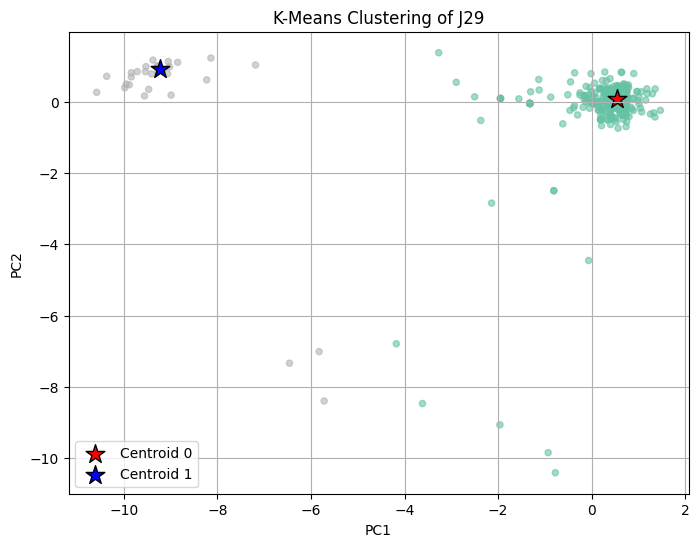

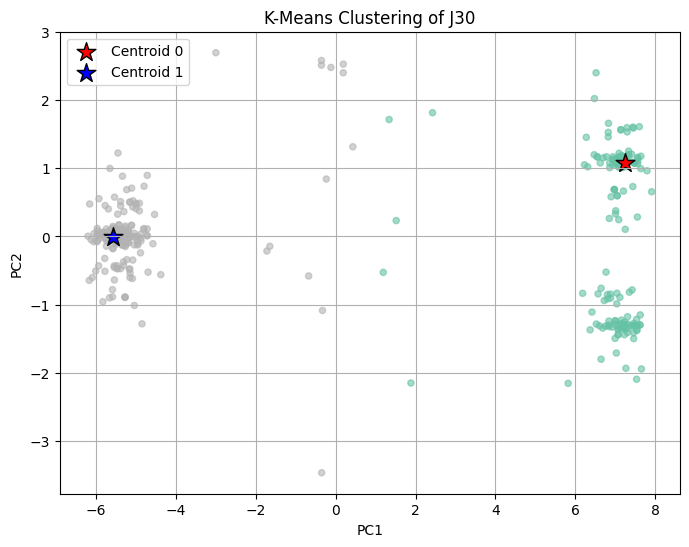

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import numpy as np

def get_kmer_vectorized(sequences, k=4):
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    X = vectorizer.fit_transform(sequences)
    return X

def get_representative_indices(X_array, labels, kmeans):
    reps_idx = []
    for cluster_idx in range(kmeans.n_clusters):
        cluster_indices = np.where(labels == cluster_idx)[0]
        cluster_vectors = X_array[cluster_indices]
        centroid = kmeans.cluster_centers_[cluster_idx]
        distances = np.linalg.norm(cluster_vectors - centroid, axis=1)
        closest_idx = cluster_indices[np.argmin(distances)]
        reps_idx.append(closest_idx)
    return reps_idx

def cluster_and_visualize(file_path, label, k=4, num_clusters=2):
    # Load and extract sequences
    records = list(SeqIO.parse(file_path, "fastq"))
    sequences = [str(r.seq) for r in records]

    # Vectorize with k-mers
    X = get_kmer_vectorized(sequences, k)
    X_array = X.toarray()

    # Run KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(X_array)

    # Get representative indices
    rep_indices = get_representative_indices(X_array, labels, kmeans)

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_array)

    # Plot clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set2', alpha=0.6, s=20)
    colors = ['red', 'blue']

    # Highlight representatives
    for i, idx in enumerate(rep_indices):
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                    c=colors[i], marker='*', s=200, edgecolors='black',
                    label=f"Centroid {i}")

    plt.title(f"K-Means Clustering of {label}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
cluster_and_visualize("/content/jeleni/only29&30/file1_296bp.fastq", "J29")
cluster_and_visualize("/content/jeleni/only29&30/file2_296bp.fastq", "J30")